# Replicate Fig7D from Rees et al 2016


In [5]:
from igraph import *
from bluepy.enums import Cell
from scipy import sparse
import bluepy
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import logging
from graph_analysis.triplets import MotifReader, CA1MotifCalculator

In [6]:
all_motifs = ['-C','-B','-A','A','B','C','D','E','F','G','H','I','J','K','L','M']
target = 'slice20'
save_dir = f'../../output/triplets/{target}'
os.makedirs(save_dir, exist_ok=True)


# CA1 PYR:INT

In [7]:
check_mtypes = ['SP_PC','SP_PC','SP_PC']
compare_to = ['INT','INT','INT']


target_motifs_exc = {}
target_motifs_inh = {}

for motif_name in all_motifs:
    logging.info(f"Running motif calculation for {target} of motif {motif_name} of {check_mtypes}...")
    motif_reader = MotifReader()
    CM = motif_reader.name_to_matrix(motif_name)
    # logging.info(f"Motif matrix:\n{CM}")
    calculator = CA1MotifCalculator(target,check_mtypes, CM)
    num_motifs = calculator.count_motifs()  # proj samples not used for local computations

    logging.info(f"Running motif calculation for {target} of motif {motif_name} of {compare_to}...")

    calculator2 = CA1MotifCalculator(target,compare_to, CM)
    num_motifs2 = calculator2.count_motifs()  # proj samples not used for local computations

    target_motifs_exc[motif_name] = num_motifs
    target_motifs_inh[motif_name] = num_motifs2

INFO:root:Running motif calculation for slice20 of motif -C of ['SP_PC', 'SP_PC', 'SP_PC']...
INFO:root:Total instances of given motif (-C) within the given adj matrix: 1838070914984
INFO:root:Running motif calculation for slice20 of motif -C of ['INT', 'INT', 'INT']...
INFO:root:st_index: 12524, end_index: 14085
INFO:root:st_index: 12524, end_index: 14085
INFO:root:st_index: 12524, end_index: 14085
INFO:root:Total instances of given motif (-C) within the given adj matrix: 2431936465
INFO:root:Running motif calculation for slice20 of motif -B of ['SP_PC', 'SP_PC', 'SP_PC']...
INFO:root:Total instances of given motif (-B) within the given adj matrix: 28466296326
INFO:root:Running motif calculation for slice20 of motif -B of ['INT', 'INT', 'INT']...
INFO:root:st_index: 12524, end_index: 14085
INFO:root:st_index: 12524, end_index: 14085
INFO:root:st_index: 12524, end_index: 14085
INFO:root:Total instances of given motif (-B) within the given adj matrix: 729986768
INFO:root:Running motif c

In [8]:
df1 = pd.DataFrame.from_dict(target_motifs_exc, orient='index',columns=[f'{target}_EXC'])
df2 = pd.DataFrame.from_dict(target_motifs_inh, orient='index',columns=[f'{target}_INH'])

df_ei = pd.concat([df1,df2],axis=1)

In [9]:
df_ei['ratio'] = df_ei[f'{target}_EXC']/df_ei[f'{target}_INH']

In [10]:
from bluepysnap import Circuit
c =Circuit('/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/sonata/circuit_config.json')
nodes = c.nodes['hippocampus_neurons']
target_nodes = nodes.get(target)

# count how many morph_class is INT
num_int = target_nodes[target_nodes['morph_class']=='INT'].shape[0]
num_exc = target_nodes[target_nodes['morph_class']=='PYR'].shape[0]
print(f"Number of INT cells: {num_int}")
print(f"Number of EXC cells: {num_exc}")

Number of INT cells: 1561
Number of EXC cells: 12524


In [11]:
def max_possible_triplet(num_cells):
    return num_cells*(num_cells-1)*(num_cells-2)/6

In [12]:
#normalize exc and inh values with max possible values
df_ei['ratio_norm'] = df_ei['ratio'] * (max_possible_triplet(num_int) / max_possible_triplet(num_exc))

In [13]:
df_ei.to_csv(f'{save_dir}/{target}_triplet_ratios_EI.csv')

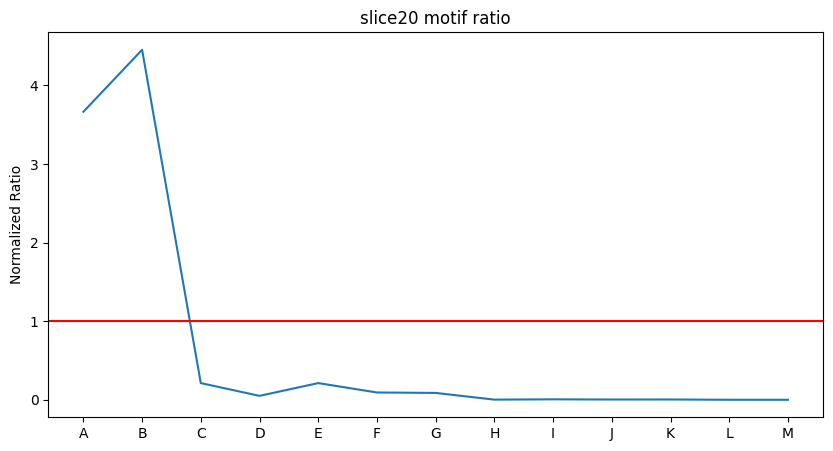

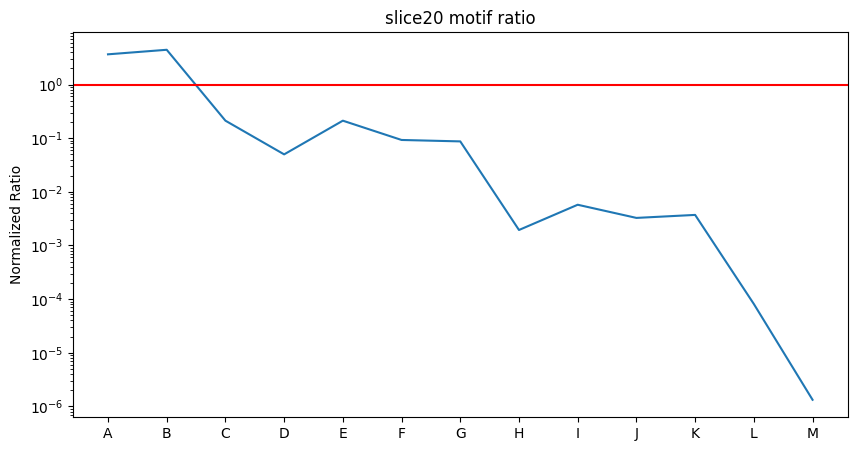

In [14]:
chosen_df = df_ei.ratio[3:]
chosen_df.plot(figsize=(10,5),title=f'{target} motif ratio')
# plot all xticklabels
plt.xticks(np.arange(len(df_ei)-3), df_ei.index[3:])
# horizontal line at y=1
plt.axhline(y=1, color='r', linestyle='-')
plt.ylabel('Normalized Ratio')
plt.savefig(f'{save_dir}/{target}_triplet_ratios_EI.png',dpi=300)
plt.show()

chosen_df.plot(figsize=(10,5),title=f'{target} motif ratio')
# plot all xticklabels
plt.xticks(np.arange(len(df_ei)-3), df_ei.index[3:])
# horizontal line at y=1
plt.yscale('log')
plt.axhline(y=1, color='r', linestyle='-')
plt.ylabel('Normalized Ratio')
plt.savefig(f'{save_dir}/{target}_triplet_ratios_EI_log.png',dpi=300)
plt.show()


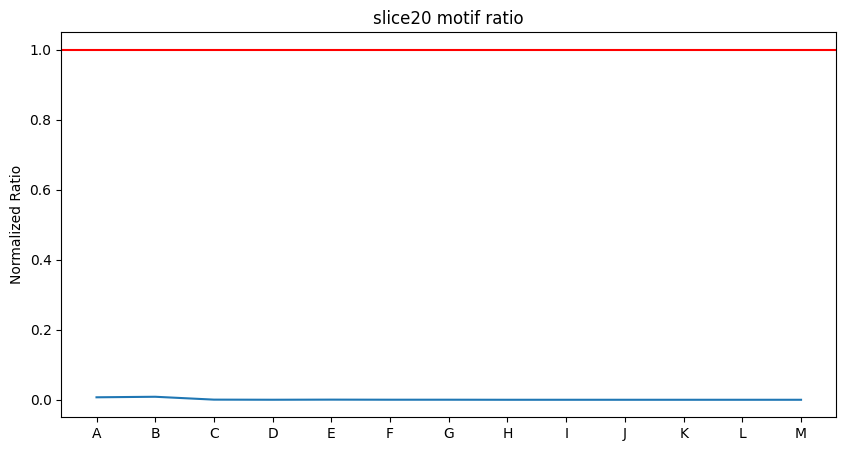

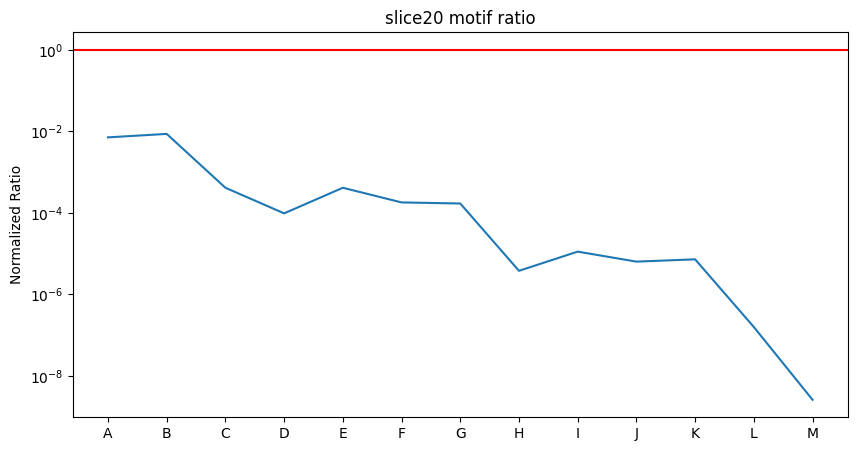

In [ ]:
chosen_df = df_ei.ratio_norm[3:]
chosen_df.plot(figsize=(10,5),title=f'{target} motif ratio')
# plot all xticklabels
plt.xticks(np.arange(len(df_ei)-3), df_ei.index[3:])
# horizontal line at y=1
plt.axhline(y=1, color='r', linestyle='-')
plt.ylabel('Normalized Ratio')
plt.savefig(f'{save_dir}/{target}_motif_ratio_EI.png')
plt.show()

chosen_df.plot(figsize=(10,5),title=f'{target} motif ratio')
# plot all xticklabels
plt.xticks(np.arange(len(df_ei)-3), df_ei.index[3:])
# horizontal line at y=1
plt.yscale('log')
plt.axhline(y=1, color='r', linestyle='-')
plt.ylabel('Normalized Ratio')
plt.savefig(f'{save_dir}/{target}_motif_ratio_EI_log.png')
plt.show()


# CA1 Perisomatic INT: Distal INT

In [16]:
check_mtypes = ['PeriSomatic_INH','PeriSomatic_INH','PeriSomatic_INH']
compare_to = ['Distal_INH','Distal_INH','Distal_INH']

target_motifs_perisomatic = {}
target_motifs_distal = {}

for motif_name in tqdm(all_motifs):
    logging.info(f"Running motif calculation for {target} of motif {motif_name} of {check_mtypes}...")
    motif_reader = MotifReader()
    CM = motif_reader.name_to_matrix(motif_name)
    # logging.info(f"Motif matrix:\n{CM}")
    calculator = CA1MotifCalculator(target,check_mtypes, CM)
    num_motifs = calculator.count_motifs()  # proj samples not used for local computations

    logging.info(f"Running motif calculation for {target} of motif {motif_name} of {compare_to}...")

    calculator2 = CA1MotifCalculator(target,compare_to, CM)
    num_motifs2 = calculator2.count_motifs()  # proj samples not used for local computations

    target_motifs_perisomatic[motif_name] = num_motifs
    target_motifs_distal[motif_name] = num_motifs2

  0%|          | 0/16 [00:00<?, ?it/s]INFO:root:Running motif calculation for slice20 of motif -C of ['PeriSomatic_INH', 'PeriSomatic_INH', 'PeriSomatic_INH']...
INFO:root:Total instances of given motif (-C) within the given adj matrix: 181972202
INFO:root:Running motif calculation for slice20 of motif -C of ['Distal_INH', 'Distal_INH', 'Distal_INH']...
INFO:root:Total instances of given motif (-C) within the given adj matrix: 470991845
  6%|▋         | 1/16 [01:03<15:50, 63.39s/it]INFO:root:Running motif calculation for slice20 of motif -B of ['PeriSomatic_INH', 'PeriSomatic_INH', 'PeriSomatic_INH']...
INFO:root:Total instances of given motif (-B) within the given adj matrix: 51491843
INFO:root:Running motif calculation for slice20 of motif -B of ['Distal_INH', 'Distal_INH', 'Distal_INH']...
INFO:root:Total instances of given motif (-B) within the given adj matrix: 105629113
 12%|█▎        | 2/16 [02:07<14:49, 63.52s/it]INFO:root:Running motif calculation for slice20 of motif -A of ['

In [17]:
df1 = pd.DataFrame.from_dict(target_motifs_perisomatic, orient='index',columns=[f'{target}_perisomatic'])
df2 = pd.DataFrame.from_dict(target_motifs_distal, orient='index',columns=[f'{target}_distal'])

df_peridistal = pd.concat([df1,df2],axis=1)
df_peridistal['ratio'] = df_peridistal[f'{target}_perisomatic']/df_peridistal[f'{target}_distal']
df_peridistal.to_csv(f'{save_dir}/{target}_triplet_ratios_peridistal.csv')

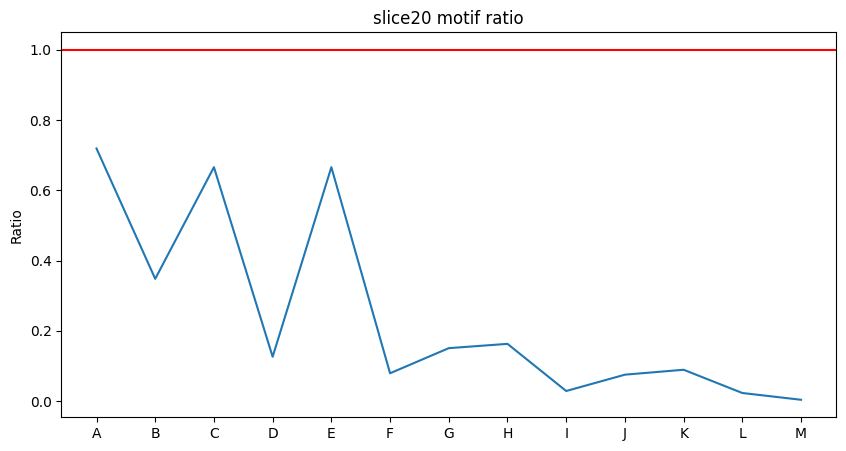

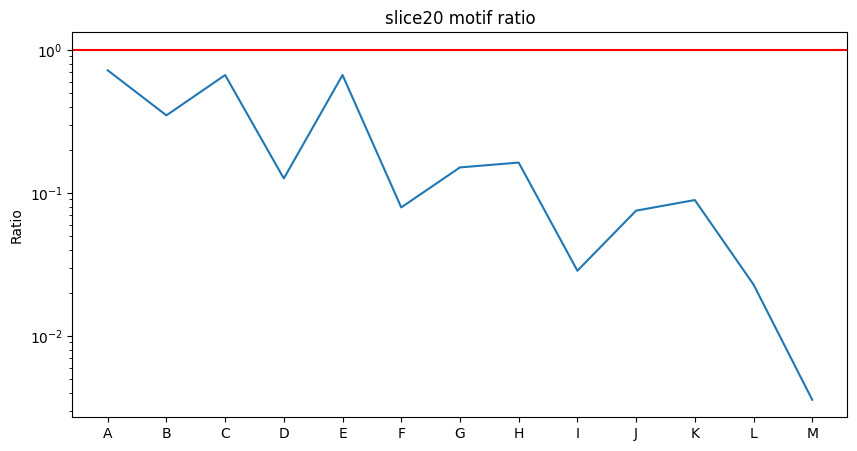

In [18]:
chosen_df = df_peridistal.ratio[3:]
chosen_df.plot(figsize=(10,5),title=f'{target} motif ratio')
# plot all xticklabels
plt.xticks(np.arange(len(df_peridistal)-3), df_peridistal.index[3:])
# horizontal line at y=1
plt.axhline(y=1, color='r', linestyle='-')
plt.ylabel('Ratio')
plt.savefig(f'{save_dir}/{target}_triplet_ratios_peridistal.png',dpi=300)
plt.show()

chosen_df.plot(figsize=(10,5),title=f'{target} motif ratio')
# plot all xticklabels
plt.xticks(np.arange(len(df_peridistal)-3), df_peridistal.index[3:])
# horizontal line at y=1
plt.yscale('log')
plt.axhline(y=1, color='r', linestyle='-')
plt.ylabel('Ratio')
plt.savefig(f'{save_dir}/{target}_triplet_ratios_peridistal_log.png',dpi=300)
plt.show()


# Combined figure 7D

In [19]:
df_ei = pd.read_csv(f'{save_dir}/{target}_triplet_ratios_EI.csv',index_col=0)
df_peridistal = pd.read_csv(f'{save_dir}/{target}_triplet_ratios_peridistal.csv',index_col=0)

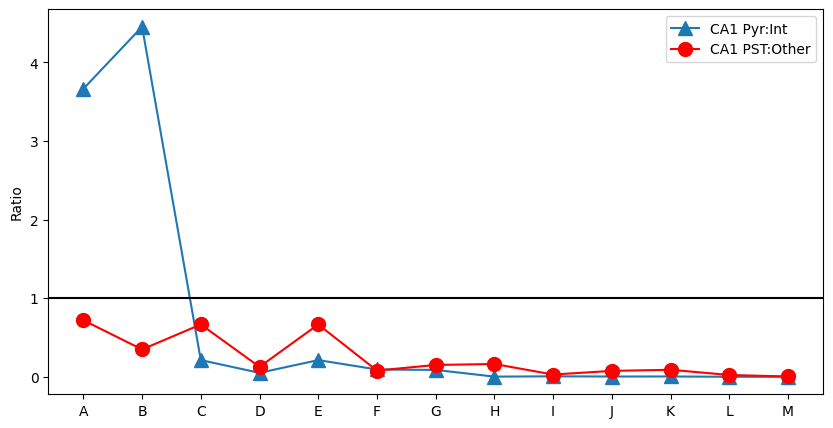

In [20]:
chosen_df1 = df_ei.ratio[3:]
# chosen_df1.plot(figsize=(10,5),title=f'{target} motif ratio')
# add black triangles and blue lines connecting for every point in the plot and lines
chosen_df1.plot(style='^-',ms=10,figsize=(10,5))

chosen_df2= df_peridistal.ratio[3:]
chosen_df2.plot(style='o-r',ms=10,figsize=(10,5))


# plot all xticklabels
plt.xticks(np.arange(len(df_peridistal)-3), df_peridistal.index[3:])
# horizontal line at y=1
plt.axhline(y=1, color='k', linestyle='-')
plt.ylabel('Ratio')
plt.legend(['CA1 Pyr:Int','CA1 PST:Other'])
plt.savefig(f'{save_dir}/{target}_Rees2016_Fig7D.png',dpi=300)
plt.show()
